In [ ]:
!pip install livelossplot

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from livelossplot import PlotLossesKeras

In [ ]:
extract_regularizer = lambda layer: str(type(layer.kernel_regularizer)).split(".")[-1][:-2]
def get_regularizer_and_value(layer):
  regularizer_name = extract_regularizer(layer) if hasattr(layer, "kernel_regularizer") and extract_regularizer(layer) in ["L1", "L2"] else None
  if regularizer_name:
    isL1 = regularizer_name == "L1"
    value = layer.kernel_regularizer.l1 if isL1 else layer.kernel_regularizer.l2
    regularizer_name = regularizer_name + "=" + str(value)
  return regularizer_name

def table_summary_model(model):
  table=pd.DataFrame(columns=["Name","Type","Shape", "# Params", "Activation", "Regularizer"])
  for layer in model.layers:
    activation_fn_name = layer.activation.__name__ if hasattr(layer, "activation") else None
    regularizer_name = get_regularizer_and_value(layer)
    table = table.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape, "Activation": activation_fn_name, "# Params": layer.count_params(), "Regularizer": regularizer_name}, ignore_index=True)
  return table

def latex_table_summary(model):
  table = table_summary_model(model)
  print(table.to_latex(index=False))
  return

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def get_class_distribution(y):
  unique, counts = np.unique(y, return_counts=True)
  return dict(zip(unique, counts))
get_class_distribution(y_train),get_class_distribution(y_test)

({0: 5923,
  1: 6742,
  2: 5958,
  3: 6131,
  4: 5842,
  5: 5421,
  6: 5918,
  7: 6265,
  8: 5851,
  9: 5949},
 {0: 980,
  1: 1135,
  2: 1032,
  3: 1010,
  4: 982,
  5: 892,
  6: 958,
  7: 1028,
  8: 974,
  9: 1009})

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

In [ ]:
num_of_unique_labels = len(np.unique(np.concatenate([y_train, y_test])))

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_of_unique_labels)
y_test = tf.keras.utils.to_categorical(y_test, num_of_unique_labels)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def calculate_class_weights(y, categorical=False):
  y_ = np.argmax(y, axis=1) if categorical else y
  class_weights = compute_class_weight('balanced', classes=np.unique(y_), y=y_)
  class_weight_dict = dict(enumerate(class_weights))
  return class_weight_dict

In [ ]:
def plot_acc_ls(avg_loss_t, avg_acc_t, avg_loss_v, avg_acc_v):
  plt.figure(figsize=(12, 4))

  # Loss Plot
  plt.subplot(1, 2, 1)
  plt.plot(avg_loss_t, label='Average Training Loss')
  plt.plot(avg_loss_v, label='Average Validation Loss')
  plt.title('Average Loss Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy Plot
  plt.subplot(1, 2, 2)
  plt.plot(avg_acc_t, label='Average Training Accuracy')
  plt.plot(avg_acc_v, label='Average Validation Accuracy')
  plt.title('Average Accuracy Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()
  return

def collect_data(history, scores, all_fold_loss_t, all_fold_acc_t, all_fold_loss_v, all_fold_acc_v, acc_per_fold, loss_per_fold):
  all_fold_loss_t.append(history.history['loss'])
  all_fold_acc_t.append(history.history['acc'])
  all_fold_loss_v.append(history.history['val_loss'])
  all_fold_acc_v.append(history.history['val_acc'])
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  return all_fold_loss_t, all_fold_acc_t, all_fold_loss_v, all_fold_acc_v, acc_per_fold, loss_per_fold

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
def kfold_cv(model_fn, X, y, k, epochs, batch_size=32, verbose=0, strat=False, callbacks=[]):
  acc_per_fold,all_fold_acc_t,all_fold_acc_v, = [], [], []
  loss_per_fold, all_fold_loss_t,all_fold_loss_v = [], [], []
  fold_no = 0
  kf = KFold(n_splits=k) if not strat else StratifiedKFold(n_splits=k)
  input_data, targets = np.array(X), np.array(y)
  for train, test in kf.split(input_data, targets):
    fold_no += 1
    m = None
    m = model_fn()
    xtrain, xtest = input_data[train], input_data[test]
    class_weight_dict = calculate_class_weights(targets[train], categorical=True)
    history = m.fit(xtrain, targets[train],
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              callbacks=callbacks,
              validation_data=(xtest, targets[test]),
              class_weight=class_weight_dict)
    scores = m.evaluate(xtest, targets[test], verbose=0)
    collect_data(history, scores, all_fold_loss_t, all_fold_acc_t, all_fold_loss_v, all_fold_acc_v, acc_per_fold, loss_per_fold)
    print(f'Score for fold {fold_no}: {m.metrics_names[0]} of {scores[0]}; {m.metrics_names[1]} of {scores[1]*100}%')
  avg_loss_t = np.mean(all_fold_loss_t, axis=0)
  avg_acc_t = np.mean(all_fold_acc_t, axis=0)
  avg_loss_v = np.mean(all_fold_loss_v, axis=0)
  avg_acc_v = np.mean(all_fold_acc_v, axis=0)
  plot_acc_ls(avg_loss_t, avg_acc_t, avg_loss_v, avg_acc_v)
  return m, acc_per_fold, loss_per_fold

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#BASELINE

In [ ]:
def create_baseline_model():
  model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
  ])
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])
  return model

In [ ]:
BASELINE_EPOCHS = 10
BASELINE_BATCH_SIZE = 32
BASELINE_CALLBACKS = [PlotLossesKeras()]

In [ ]:
class_weights = calculate_class_weights(y_train, categorical=True)
class_weights

{0: 1.0130001688333614,
 1: 0.8899436369029962,
 2: 1.0070493454179255,
 3: 0.978633175664655,
 4: 1.0270455323519343,
 5: 1.1068068622025458,
 6: 1.013856032443393,
 7: 0.9577015163607342,
 8: 1.025465732353444,
 9: 1.0085728693898135}

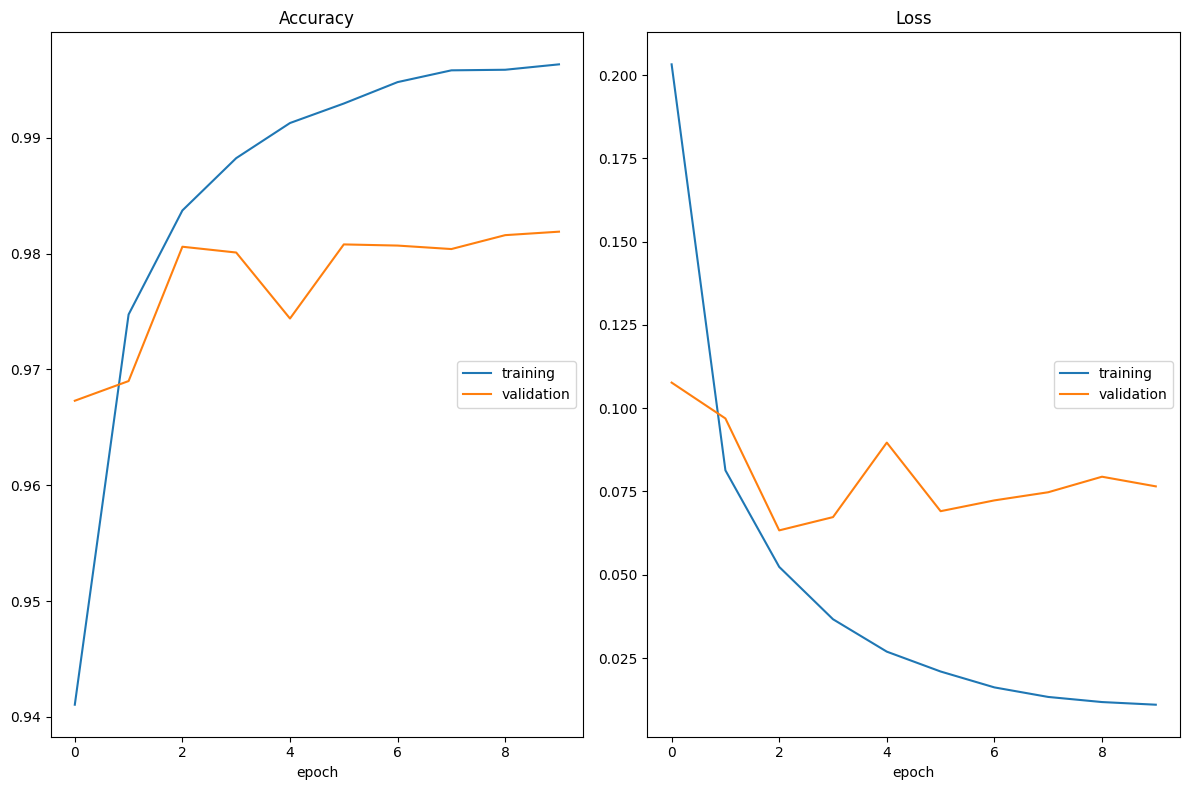

Accuracy
	training         	 (min:    0.941, max:    0.996, cur:    0.996)
	validation       	 (min:    0.967, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.011, max:    0.203, cur:    0.011)
	validation       	 (min:    0.063, max:    0.108, cur:    0.077)


In [ ]:
bl_m = create_baseline_model()
bl_h = bl_m.fit(
    X_train,
    y_train,
    epochs=BASELINE_EPOCHS,
    batch_size=BASELINE_BATCH_SIZE,
    callbacks=BASELINE_CALLBACKS,
    validation_data=(X_test,y_test),
    verbose=0,
    class_weight=class_weights
)

In [ ]:
bl_m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_pred = bl_m.predict(X_test).argmax(axis=1)
bl_cr = classification_report(y_test.argmax(axis=1), y_pred)
bl_cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

313/313 [==============================] - 1s 3ms/step


In [ ]:
print(pd.DataFrame(bl_cm).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    0 &     1 &     2 &    3 &    4 &    5 &    6 &     7 &    8 &    9 \\
\midrule
0 &  970 &     1 &     1 &    2 &    1 &    1 &    1 &     0 &    2 &    1 \\
1 &    0 &  1128 &     0 &    1 &    0 &    0 &    2 &     0 &    4 &    0 \\
2 &    2 &     2 &  1001 &    6 &    3 &    0 &    2 &     5 &   10 &    1 \\
3 &    0 &     0 &     2 &  995 &    0 &    4 &    0 &     3 &    2 &    4 \\
4 &    2 &     0 &     3 &    1 &  949 &    1 &    5 &     4 &    2 &   15 \\
5 &    2 &     0 &     0 &    8 &    0 &  875 &    3 &     0 &    3 &    1 \\
6 &    0 &     1 &     0 &    0 &    1 &    3 &  953 &     0 &    0 &    0 \\
7 &    0 &     4 &     4 &    2 &    0 &    0 &    0 &  1002 &    4 &   12 \\
8 &    0 &     1 &     1 &    8 &    0 &    2 &    0 &     3 &  956 &    3 \\
9 &    2 &     2 &     0 &    3 &    4 &    3 &    1 &     1 &    3 &  990 \\
\bottomrule
\end{tabular}



<ipython-input-45-6eb1e0677e3f>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(bl_cm).to_latex())


In [ ]:
def create_model():
  model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'), #128
    Dropout(.5),
    Dense(128, activation='relu'), #128; 64; 16; 32 funguje dobre na 98%
    Dropout(.5),
    Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    Dropout(.3),
    Dense(16, activation="relu", kernel_regularizer=L2()),
    Dense(10, activation='softmax')
  ])
  model.compile(
      loss="categorical_crossentropy",
      optimizer=Adam(.01),
      metrics=["acc"]
  )
  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
CALLBACKS = [
    PlotLossesKeras(),
    ReduceLROnPlateau(patience=7),
    ModelCheckpoint("model.h5", save_best_only=True),
    EarlyStopping(patience=15),
]

In [ ]:
m2 = create_model()
#m2.summary()

In [ ]:
latex_table_summary(m)

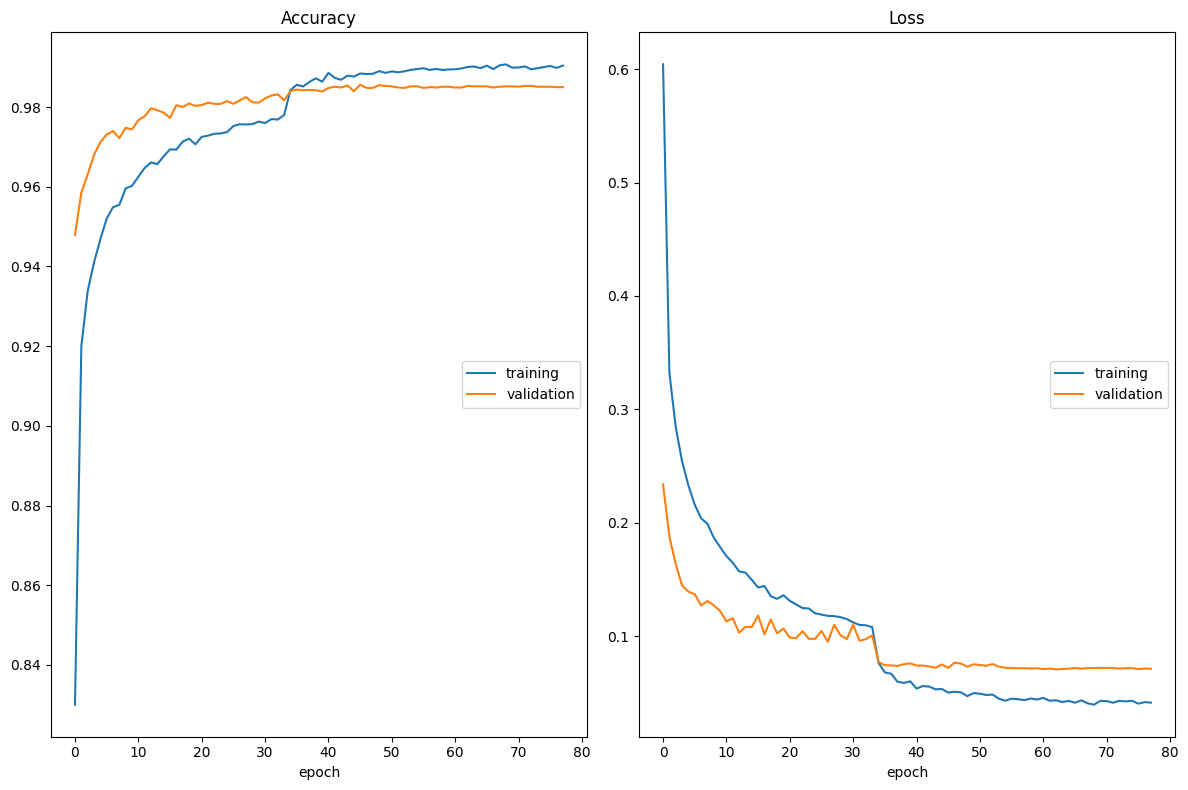

Accuracy
	training         	 (min:    0.830, max:    0.991, cur:    0.990)
	validation       	 (min:    0.948, max:    0.986, cur:    0.985)
Loss
	training         	 (min:    0.040, max:    0.604, cur:    0.042)
	validation       	 (min:    0.071, max:    0.234, cur:    0.071)


In [ ]:
m2_h = m2.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=CALLBACKS,
    validation_data=(X_test,y_test),
    verbose=0,
    class_weight=class_weights
)

In [ ]:
m2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_46 (Dense)            (None, 512)               401920    
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_47 (Dense)            (None, 128)               65664     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 32)                4128      
                                                                 
 batch_normalization_9 (Bat  (None, 32)              

In [ ]:
y_pred = m2.predict(X_test).argmax(axis=1)
cr = classification_report(y_test.argmax(axis=1), y_pred)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

313/313 [==============================] - 3s 9ms/step
